In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

In [3]:
from m5.functions import *
%aimport m5.functions

In [306]:
prediction_length = 28
last_day = 1913 + 2*prediction_length

In [372]:
ts_sales = pd.read_pickle('../ts_prices_sales.pk')
date_index = ts_sales['date']
ts_sales = ts_sales.set_index(date_index)

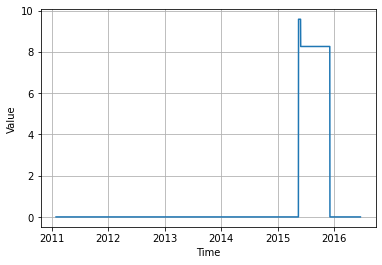

In [374]:
# ts_sales['slp_HOBBIES_1_001_CA_1'].unique()
plot_series(ts_sales.index, ts_sales['slp_HOBBIES_1_001_CA_1'])

In [460]:
calculated = list(filter(is_added_column, ts_sales.columns))
ts_sales = ts_sales.drop(calculated, axis=1)

item_id = 'HOBBIES_1_008'
agg_keys = []
mean_agg_keys = []
shop_id = 'CA_1'
item = item_id + '_' + shop_id
# item = item_id + '_' + state_id + '_1'
for state_id in ['CA', 'TX', 'WI']:    
    agg_key = aggregate([item_id, state_id], ts_sales)
    agg_keys.append(agg_key) 
    
for state_id in ['CA', 'TX', 'WI']:    
    agg_key = aggregate(['HOBBIES_1', state_id], ts_sales)
    agg_keys.append(agg_key)     
    
for key in agg_keys + [item]:        
    for i in [7, 28]:        
        mean_agg_key = 'mean_' + str(i) + '_' + key
#         print(key)
        # sales a month before
        ts_sales[mean_agg_key] = ts_sales[[key, 'd']].apply(sma, axis=1, window=i, monthly=np.array([0]*i))
        mean_agg_keys.append(mean_agg_key)

In [463]:
prediction_start = 1000
validation_lenght = prediction_length
# 1913 - 28
# validation_end = last_day
validation_end = 1913 - 28
validation_start = validation_end - validation_lenght

In [461]:
mean_cm = agg_keys + mean_agg_keys
lag_columns = ['lag_' + str(i) + '_' + item for i in [28]]
train_columns = ['wday', 'month', 'event_name_1_ord', 'event_name_2_ord', 'snap_CA'] 
train_columns = ['slp_' + item] + train_columns + lag_columns + mean_cm
Xy = ts_sales[[item] + train_columns][0:-prediction_length].copy()
print(Xy.columns)

Index(['HOBBIES_1_008_CA_1', 'slp_HOBBIES_1_008_CA_1', 'wday', 'month',
       'event_name_1_ord', 'event_name_2_ord', 'snap_CA',
       'lag_28_HOBBIES_1_008_CA_1', 'agg_HOBBIES_1_008_CA',
       'agg_HOBBIES_1_008_TX', 'agg_HOBBIES_1_008_WI', 'agg_HOBBIES_1_CA',
       'agg_HOBBIES_1_TX', 'agg_HOBBIES_1_WI', 'mean_7_agg_HOBBIES_1_008_CA',
       'mean_28_agg_HOBBIES_1_008_CA', 'mean_7_agg_HOBBIES_1_008_TX',
       'mean_28_agg_HOBBIES_1_008_TX', 'mean_7_agg_HOBBIES_1_008_WI',
       'mean_28_agg_HOBBIES_1_008_WI', 'mean_7_agg_HOBBIES_1_CA',
       'mean_28_agg_HOBBIES_1_CA', 'mean_7_agg_HOBBIES_1_TX',
       'mean_28_agg_HOBBIES_1_TX', 'mean_7_agg_HOBBIES_1_WI',
       'mean_28_agg_HOBBIES_1_WI', 'mean_7_HOBBIES_1_008_CA_1',
       'mean_28_HOBBIES_1_008_CA_1'],
      dtype='object')


In [464]:
XyLags = Xy[[item] + train_columns]
XyLags = XyLags.dropna()
X_train = XyLags[prediction_start:validation_start][train_columns]
y_train = XyLags[prediction_start:validation_start][item]
X_test = XyLags[validation_start:validation_end][train_columns]
y_test = XyLags[validation_start:validation_end][item]
gb = GradientBoostingRegressor(n_estimators=250)
gb.fit(X_train, y_train)
y_hat = gb.predict(X_test)    
np.sqrt(((y_hat - y_test)**2).mean())

7.2518335581406586

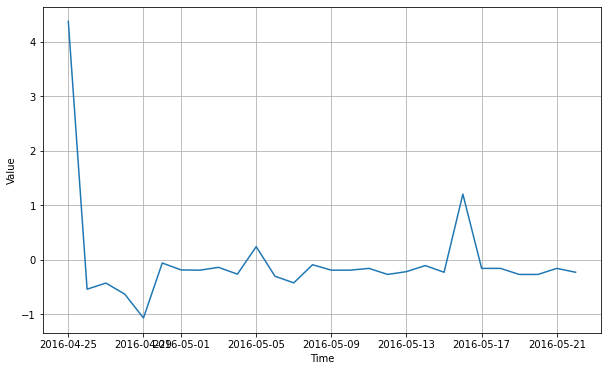

In [452]:
plt.figure(figsize=(10, 6))
start_index = 19
plot_series(Xy.index[1913:], y_hat)
# plot_series(ts_sales.index[validation_start:validation_end], y_test)
# plot_series(ts_sales.index[validation_start:validation_end], y_hat)

In [ ]:
columns = ['id'] + ['F' + str(i) for i in range(1,29)]
series = []
for i,v in enumerate(['validation', 'evaluation']):
    series.append([item + '_' + v] + list(y_hat[28*i:28*(i + 1)]))
submission = pd.DataFrame(series, columns=columns)

In [ ]:
submission